# Information Elements Categorical Embeddings

In [ ]:
# TODO: redo

## Libraries and Configurations

Import configuration files

In [318]:
from configparser import ConfigParser

config = ConfigParser()
config.read("../config.ini")

['../config.ini']

Import **data libraries**

In [319]:
import pandas as pd

Import **ML libraries**

In [320]:
from sklearn import preprocessing
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models

Import **other libraries**

In [321]:
import numpy as np

from rich.progress import Progress
from rich import traceback

traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x10c1bd350>>

Custom helper scripts

In [322]:
%cd ..
from scripts import plotHelper, encodingHelper
%cd data_exploration_cleaning

/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks
/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/notebooks/data_exploration_cleaning


/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import Data

In [323]:
# Combined dataframe
combined_df_csv = config["DEFAULT"]["interim_path"] + "balanced_df_raw.csv"

In [324]:
df = pd.read_csv(combined_df_csv, index_col=0)

Keeping only categorical columns to be encoded

In [325]:
df = df[["HT Capabilities", "Extended Capabilities", "Vendor Specific Tags", "Label"]]

In [326]:
df

,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Label
0,2d001bff00000000000000000000000000000000000000...,80000000040000020,NaN,iPhone12Pro_C
1,2d001bff00000000000000000000000000000000000000...,80000000040000020,NaN,iPhone12Pro_C
2,2d001bff00000000000000000000000000000000000000...,80000000040000020,NaN,iPhone12Pro_C
3,2d001bff00000000000000000000000000000000000000...,80000000040000020,NaN,iPhone12Pro_C
4,2d001bff00000000000000000000000000000000000000...,80000000040000020,NaN,iPhone12Pro_C
...,...,...,...,...
13939,2d0113ff00000000000000000000000000000000000000...,04000a02004000408001,0050f208002400,XiaomiRedmiNote7_S
13940,2d0113ff00000000000000000000000000000000000000...,04000a02004000408001,0050f208002400,XiaomiRedmiNote7_S
13941,2d0113ff00000000000000000000000000000000000000...,04000a02004000408001,0050f208002400,XiaomiRedmiNote7_S
13942,2d0113ff00000000000000000000000000000000000000...,04000a02004000408001,0050f208002400,XiaomiRedmiNote7_S


In [327]:
df = df.rename(
    columns={
        "HT Capabilities": "HT_Capabilities",
        "Extended Capabilities": "Extended_Capabilities",
        "Vendor Specific Tags": "Vendor_Specific_Tags",
    }
)

In [328]:
label_encoder = preprocessing.LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])

Selecting categorical features

In [329]:
features = [f for f in df.columns if f != "Label"]

In [330]:
features

['HT_Capabilities', 'Extended_Capabilities', 'Vendor_Specific_Tags']

## Label Encoding

In [331]:
for feat in features:
    encoder = preprocessing.LabelEncoder()
    df.loc[:, feat] = encoder.fit_transform(df[feat].astype(str).fillna("-1").values)

In [332]:
df

,HT_Capabilities,Extended_Capabilities,Vendor_Specific_Tags,Label
0,6,17,62,23
1,6,17,62,23
2,6,17,62,23
3,6,17,62,23
4,6,17,62,23
...,...,...,...,...
13939,8,7,25,17
13940,8,7,25,17
13941,8,7,25,17
13942,8,7,25,17


In [333]:
df

,HT_Capabilities,Extended_Capabilities,Vendor_Specific_Tags,Label
0,6,17,62,23
1,6,17,62,23
2,6,17,62,23
3,6,17,62,23
4,6,17,62,23
...,...,...,...,...
13939,8,7,25,17
13940,8,7,25,17
13941,8,7,25,17
13942,8,7,25,17


## Entity Embedding

Splitting `df` into train and test set

In [334]:
X = df.drop(columns=["Label"])
y = df["Label"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [335]:
X_train.shape, X_test.shape

((28836, 3), (7210, 3))

In [336]:
def get_model(df: pd.DataFrame, categorical_columns: str) -> models.Model:
    inputs = []
    outputs = []

    for c in categorical_columns:
        num_unique_values = int(df[c].nunique())
        embed_dim = int(min(np.ceil((num_unique_values) / 2), 50))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim)(inp)
        out = layers.Reshape(target_shape=(embed_dim,))(out)
        inputs.append(inp)
        outputs.append(out)

    x = layers.Concatenate()(outputs)
    x = layers.Dense(300, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    y = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=inputs, outputs=y)

    return model

In [337]:
model = get_model(X_train, features)
model.compile(
    loss="binary_crossentropy", optimizer=optimizers.Adam(0.001), metrics=["mae"]
)

In [338]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_37 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_38 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_39 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_27 (Embedding)    (None, 1, 12)                288       ['input_37[0][0]']            
                                                                                           

In [339]:
x = [X_train.loc[:, f].values for f in features]

x = [np.asarray(x[i]).astype("float32") for i in range(len(x))]

x

[array([13., 19., 22., ..., 12., 11., 13.], dtype=float32),
 array([19.,  5., 25., ..., 23., 19., 19.], dtype=float32),
 array([62., 18., 26., ...,  1., 62., 62.], dtype=float32)]

In [340]:
xt = [X_test.loc[:, f].values for f in features]

xt = [np.asarray(xt[i]).astype("float32") for i in range(len(xt))]

xt

[array([ 4.,  8., 12., ..., 13., 17., 11.], dtype=float32),
 array([11.,  7., 23., ..., 19.,  0., 19.], dtype=float32),
 array([62., 25.,  1., ..., 62.,  3., 62.], dtype=float32)]

In [341]:
ie_fit = model.fit(
    x,
    y_train,
    epochs=5,
    batch_size=32,
    validation_data=(xt, y_test),
)

Epoch 1/5


902/902 [==============================] - 6s 4ms/step - loss: -29364568.0000 - mae: 14.0385 - val_loss: -150078816.0000 - val_mae: 14.1226
Epoch 2/5
902/902 [==============================] - 3s 3ms/step - loss: -820382848.0000 - mae: 14.0289 - val_loss: -2002285952.0000 - val_mae: 14.1226
Epoch 3/5
902/902 [==============================] - 3s 3ms/step - loss: -4536791040.0000 - mae: 14.0289 - val_loss: -8092034048.0000 - val_mae: 14.1226
Epoch 4/5
902/902 [==============================] - 3s 3ms/step - loss: -13691525120.0000 - mae: 14.0289 - val_loss: -20885313536.0000 - val_mae: 14.1226
Epoch 5/5
902/902 [==============================] - 3s 3ms/step - loss: -30698991616.0000 - mae: 14.0289 - val_loss: -42768187392.0000 - val_mae: 14.1226


In [342]:
model.save(config["DEFAULT"]["models_path"] + "IE_embeddings.h5")

/Users/bacci/Library/CloudStorage/SynologyDrive-giovanni/Research 🌱/Repositories/COMPACT/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [343]:
import matplotlib.pyplot as plt

In [344]:
ie_fit.history

{'loss': [-29364568.0,
  -820382848.0,
  -4536791040.0,
  -13691525120.0,
  -30698991616.0],
 'mae': [14.038498878479004,
  14.028887748718262,
  14.028887748718262,
  14.028887748718262,
  14.028887748718262],
 'val_loss': [-150078816.0,
  -2002285952.0,
  -8092034048.0,
  -20885313536.0,
  -42768187392.0],
 'val_mae': [14.122607231140137,
  14.122607231140137,
  14.122607231140137,
  14.122607231140137,
  14.122607231140137]}

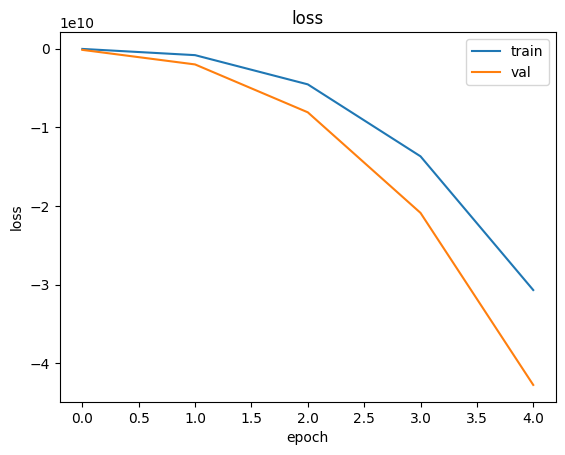

In [345]:
# summarize history for loss
plt.plot(ie_fit.history["loss"])
plt.plot(ie_fit.history["val_loss"])
plt.title("loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")

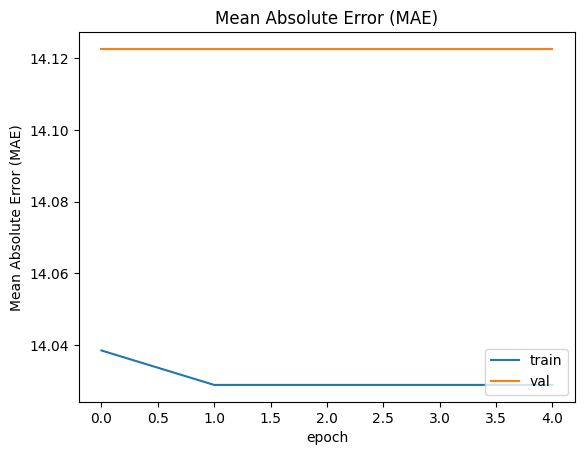

In [346]:
# summarize history for mae
plt.plot(ie_fit.history["mae"])
plt.plot(ie_fit.history["val_mae"])
plt.title("Mean Absolute Error (MAE)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="lower right")
plt.show()

In [347]:
import seaborn as sns

226/226 [==============================] - 0s 1ms/step


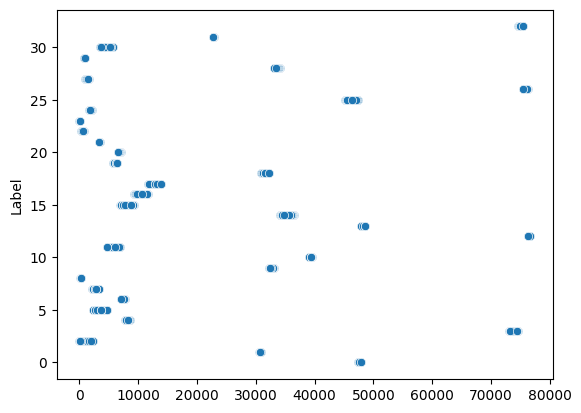

In [354]:
# Make prediction
y_test_predict = model.predict(xt)

# Change the predictions from 2-d to 1-d
y_test_predict = y_test_predict.flatten()

# Visualization
ax = sns.scatterplot(y_test)

In [351]:
# Import library
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

# Mean squared error
MSE = mean_squared_error(y_test, y_test_predict)
# Root mean squared error
RMSE = np.sqrt(MSE)
# Mean absolute error
MAE = mean_absolute_error(y_test, y_test_predict)

R2 = r2_score(y_test, y_test_predict)
MAPE = mean_absolute_percentage_error(y_test, y_test_predict)

print(f"The MSE for the model is {MSE:.2f}")
print(f"The RMSE for the model is {RMSE:.2f}.")
print(f"The MAE for the model is {MAE:.2f}.")
print(f"The R-squared for the model is {R2:.2f}.")
print(f"The MAPE for the model is {MAPE:.2f}.")

The MSE for the model is 278.55
The RMSE for the model is 16.69.
The MAE for the model is 14.12.
The R-squared for the model is -2.49.
The MAPE for the model is 61838607920899.50.


In [352]:
model.get_weights()

[array([[-6.73267174e+00, -6.85168219e+00, -6.75687933e+00,
         -6.82016182e+00, -6.79097176e+00, -6.80512047e+00,
          6.81992626e+00,  6.81412888e+00,  6.80815506e+00,
          6.76624823e+00, -6.81525040e+00,  6.77958250e+00],
        [-5.20188427e+00, -5.19600248e+00, -5.19160748e+00,
         -5.22041559e+00, -5.19275284e+00, -5.23900747e+00,
          5.22896957e+00,  5.17739439e+00,  5.18180895e+00,
          5.15351868e+00, -5.14018917e+00,  5.15876198e+00],
        [-6.83226776e+00, -6.88619328e+00, -6.87375212e+00,
         -6.80765963e+00, -6.89446974e+00, -6.82827330e+00,
          6.80245447e+00,  6.81690311e+00,  6.84332371e+00,
          6.85930634e+00, -6.88234949e+00,  6.85293722e+00],
        [-5.32527399e+00, -5.27605963e+00, -5.26948166e+00,
         -5.31433535e+00, -5.27258730e+00, -5.34112930e+00,
          5.33173132e+00,  5.31044006e+00,  5.29778337e+00,
          5.35299015e+00, -5.23007250e+00,  5.30415058e+00],
        [-6.37184429e+00, -6.3387522

In [367]:
model.get_layer("embedding_29").get_weights()

[array([[-5.2087722e+00, -5.1513419e+00, -5.1877289e+00, ...,
         -5.1679068e+00,  5.1658778e+00,  5.1512427e+00],
        [-6.5361958e+00, -6.5117579e+00, -6.5503068e+00, ...,
         -6.5651164e+00,  6.4838090e+00,  6.5342207e+00],
        [-1.2259825e+00, -1.1870910e+00, -1.2171381e+00, ...,
         -1.1364200e+00,  1.2119970e+00,  1.1663653e+00],
        ...,
        [-1.6779377e-01, -1.6909932e-01, -1.7121664e-01, ...,
         -7.6173820e-02,  1.5872787e-01,  1.5628217e-01],
        [-7.9891009e+00, -7.9814663e+00, -7.9343653e+00, ...,
         -7.9852648e+00,  7.9641314e+00,  7.9500737e+00],
        [ 2.6535895e-02,  2.2736300e-02,  4.5584831e-02, ...,
          2.5931325e-02,  1.9146204e-03, -4.5380533e-02]], dtype=float32)]

In [368]:
# Get weights from the embedding layer
cat_emb_df = pd.DataFrame(
    model.get_layer("embedding_29").get_weights()[0]
).reset_index()

# Add prefix to the embedding names
cat_emb_df = cat_emb_df.add_prefix("cat_")

# Take a look at the data
cat_emb_df

,cat_index,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,cat_7,cat_8,...,cat_22,cat_23,cat_24,cat_25,cat_26,cat_27,cat_28,cat_29,cat_30,cat_31
0,0,-5.208772,-5.151342,-5.187729,5.187589,-5.218311,5.136966,-5.125950,-5.193750,5.229952,...,5.237866,5.153193,5.224887,5.180232,5.153980,-5.179638,5.179763,-5.167907,5.165878,5.151243
1,1,-6.536196,-6.511758,-6.550307,6.572656,-6.537984,6.565504,-6.520498,-6.511844,6.471771,...,6.488903,6.519551,6.482825,6.488256,6.564821,-6.582056,6.516785,-6.565116,6.483809,6.534221
2,2,-1.225983,-1.187091,-1.217138,1.175660,-1.217010,1.180864,-1.138372,-1.155647,1.148461,...,1.170291,1.136801,1.170840,1.143841,1.141006,-1.217839,1.158167,-1.136420,1.211997,1.166365
3,3,-7.297671,-7.378102,-7.381123,7.418231,-7.366681,7.415013,-7.381220,-7.339703,7.404626,...,7.352578,7.396435,7.328333,7.354151,7.351043,-7.371624,7.337530,-7.369288,7.403069,7.343188
4,4,-3.946241,-4.003559,-3.997959,4.035979,-4.038191,3.977697,-3.952352,-4.016108,4.024215,...,4.032695,4.016788,3.972985,4.022671,4.004601,-3.967523,4.038710,-3.975360,4.010592,3.959343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,2.791670,2.812939,2.815392,-2.761968,2.789352,-2.782144,2.812645,2.839915,-2.758791,...,-2.764552,-2.831847,-2.772717,-2.829548,-2.774689,2.791218,-2.835068,2.749190,-2.779306,-2.802949
60,60,-0.055018,-0.024270,0.014322,0.026959,-0.012587,-0.048754,-0.014037,0.001565,0.026155,...,-0.032835,-0.043771,0.024530,-0.012836,-0.023113,-0.015279,-0.009075,0.044413,0.042213,0.010865
61,61,-0.167794,-0.169099,-0.171217,0.162305,-0.110856,0.103204,-0.087704,-0.146574,0.109354,...,0.165967,0.150333,0.102273,0.081422,0.127049,-0.085083,0.146630,-0.076174,0.158728,0.156282
62,62,-7.989101,-7.981466,-7.934365,7.996830,-7.950200,7.963165,-7.931726,-7.929261,7.972006,...,7.974611,7.976761,7.922723,7.979116,7.976982,-7.980980,7.963012,-7.985265,7.964131,7.950074
